In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import norm

from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

In [8]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [9]:
train.shape
test.shape

(1460, 81)

(1459, 80)

In [56]:
train = train.drop('Id',axis=1)
test_id = test['Id']
test = test.drop('Id',axis=1)

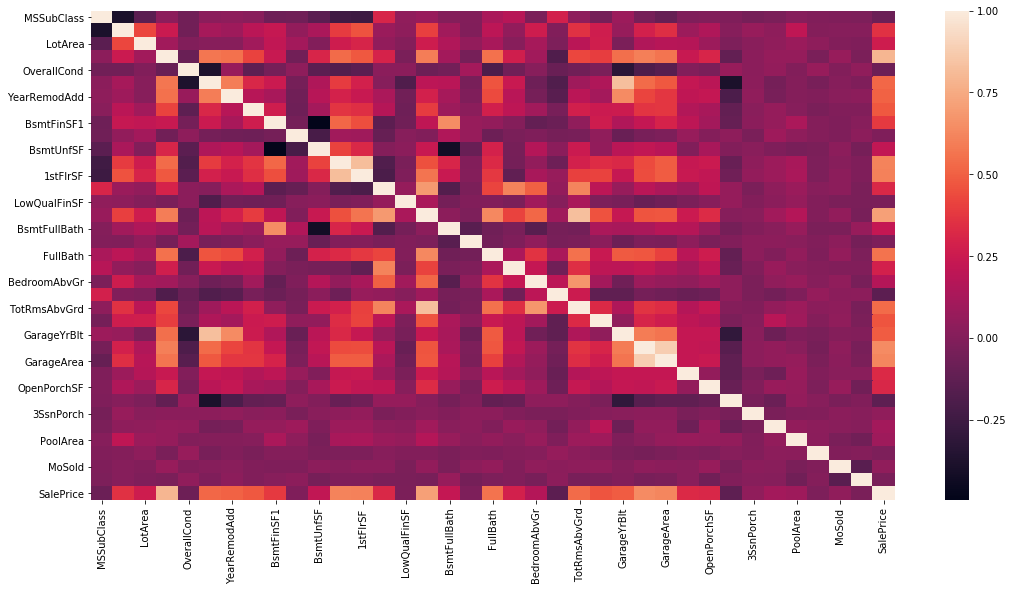

In [57]:
cormatrix = train.corr()
sns.heatmap(cormatrix)
plt.gcf().set_size_inches(18,9)
plt.show()

In [64]:
cat_index = train.dtypes[train.dtypes == "object"].index
num_index = train.dtypes[train.dtypes != "object"].index
num_index

Index([u'MSSubClass', u'LotFrontage', u'LotArea', u'OverallQual',
       u'OverallCond', u'YearBuilt', u'YearRemodAdd', u'MasVnrArea',
       u'BsmtFinSF1', u'BsmtFinSF2', u'BsmtUnfSF', u'TotalBsmtSF', u'1stFlrSF',
       u'2ndFlrSF', u'LowQualFinSF', u'GrLivArea', u'BsmtFullBath',
       u'BsmtHalfBath', u'FullBath', u'HalfBath', u'BedroomAbvGr',
       u'KitchenAbvGr', u'TotRmsAbvGrd', u'Fireplaces', u'GarageYrBlt',
       u'GarageCars', u'GarageArea', u'WoodDeckSF', u'OpenPorchSF',
       u'EnclosedPorch', u'3SsnPorch', u'ScreenPorch', u'PoolArea', u'MiscVal',
       u'MoSold', u'YrSold', u'SalePrice'],
      dtype='object')

In [75]:
half_num_index = []
count_index = []
for index in num_index:
    count = len(train[index].unique())
    if count < 30:
        half_num_index.append(index)
        count_index.append(count)
half_num_index
count_index

['MSSubClass',
 'OverallQual',
 'OverallCond',
 'LowQualFinSF',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageCars',
 '3SsnPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold']

[15, 10, 9, 24, 4, 3, 4, 3, 8, 4, 12, 4, 5, 20, 8, 21, 12, 5]

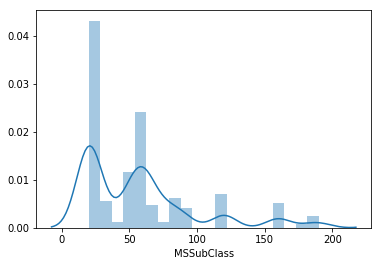

In [74]:
sns.distplot(train['MSSubClass'])